# Загружаем и смотрим датасет

In [281]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.impute import KNNImputer

# Достаем таблицу
df = pd.read_csv('data/cian_parsed.csv')

# Отображаем
df.head(5)

,author,author_type,url,location,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,...,heating_type,finish_type,living_meters,kitchen_meters,phone,district,street,house_number,underground,residential_complex
0,Главстрой,developer,https://www.cian.ru/sale/flat/296921064/,Москва,sale,flat,2,16,1,45.0,...,-1,Без отделки,"16,4 м²","14,6 м²",+74951379308,Филевский парк,Береговой проезд,2,Фили,Береговой-2
1,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/299890518/,Москва,sale,flat,9,40,1,41.5,...,-1,-1,"23,4 м²","4,9 м²",+79646331510,Хорошевский,Ленинградский проспект,37/4,ЦСКА,Прайм Парк
2,PROНЕДВИЖИМОСТЬ,real_estate_agent,https://www.cian.ru/sale/flat/308789447/,Москва,sale,flat,11,12,1,33.5,...,-1,-1,17 м²,7 м²,+79163568699,Чертаново Южное,3-й Дорожный проезд,6К1,Улица Академика Янгеля,NaN
3,Пионер,developer,https://www.cian.ru/sale/flat/305778449/,Москва,sale,flat,3,26,1,23.9,...,-1,"Без отделки, предчистовая, чистовая",-1,-1,+74951387048,Даниловский,NaN,NaN,Павелецкая,Хай Лайф ЖК
4,White and Broughton,real_estate_agent,https://www.cian.ru/sale/flat/301550653/,Москва,sale,flat,13,41,1,41.5,...,-1,-1,"23,4 м²","4,9 м²",+79646331510,Хорошевский,Ленинградский проспект,37/6,Аэропорт,Прайм Парк


# Обрабатываем датасет

In [ ]:

# Убираем дубликаты
df = df.drop_duplicates()

# Заменяем -1 на np.nan
df.replace(['-1', 'unknown'], np.nan, inplace=True)

# Удаляем то, где есть пропуски в price
df = df.dropna(subset=['price'])

# Вычисление среднего значения для столбца (игнорируя пропуски)
mean_value = df['author_type'].mean()
df['author_type'] = df['author_type'].fillna(mean_value)

# Заполняем пропуски в district из location
df['district'] = df['district'].fillna(df['location'])

# Заполняем пропуски в underground из location
df['underground'] = df['underground'].fillna(df['location'])

# Убираем м2 из значений
df["kitchen_meters"]=df["kitchen_meters"].str.replace("\xa0м²","").str.replace(",",".").astype(float)
df["living_meters"]=df["living_meters"].str.replace("\xa0м²","").str.replace(",",".").astype(float)

# Заполняем пропуски в living_meters из total_meters * 0.85
df['living_meters'] = df['living_meters'].fillna(df['total_meters'] * 0.85)

# Заполняем пропуски в living_meters из total_meters * 0.85
df['kitchen_meters'] = df['kitchen_meters'].fillna(df['total_meters'] * 0.3)

# Считаем цену за квадратный метр, потому что парсер не спарсил
df['price_per_meter'] = df['price'] / df['total_meters'].astype(int)

# Убираем не нужные нам данные, часть полезных к сожалению тоже
df.drop(['deal_type', 'url', 'author', 'accommodation_type', 'house_number', 'phone', 'heating_type', 'object_type', 'street', 'residential_complex', 'house_material_type', 'finish_type'], axis=1, inplace=True)

# Выбросы
min_max_values = {
    'rooms_count': (1, 5),   
    'kitchen_meters': (0, 100)
}
cleaned_ca = pd.DataFrame()
for column in df.columns:
    if column in min_max_values:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        min_value, max_value = min_max_values[column]
        filtered_column = df[column][(df[column] >= min_value) & (df[column] <= max_value)]
        cleaned_ca[column] = filtered_column.reset_index(drop=True)

df.head(20)

,author_type,location,floor,floors_count,rooms_count,total_meters,price,year_of_construction,living_meters,kitchen_meters,district,underground,price_per_meter
0,developer,Москва,2,16,1,45.00,23274675.0,2024,16.400,14.60,Филевский парк,Фили,5.172150e+05
1,real_estate_agent,Москва,9,40,1,41.50,32000000.0,-1,23.400,4.90,Хорошевский,ЦСКА,7.804878e+05
2,real_estate_agent,Москва,11,12,1,33.50,8000000.0,1972,17.000,7.00,Чертаново Южное,Улица Академика Янгеля,2.424242e+05
3,developer,Москва,3,26,1,23.90,22602971.0,2027,20.315,7.17,Даниловский,Павелецкая,9.827379e+05
4,real_estate_agent,Москва,13,41,1,41.50,31000000.0,-1,23.400,4.90,Хорошевский,Аэропорт,7.560976e+05
5,real_estate_agent,Москва,9,14,1,38.50,7000000.0,1993,18.000,8.00,Крюково,Зеленоград — Крюково,1.842105e+05
6,developer,Москва,7,36,1,40.90,30348986.0,2027,34.765,12.27,Беговой,Белорусская,7.587247e+05
7,real_estate_agent,Москва,3,20,1,59.00,61800000.0,2023,39.000,15.00,Пресненский,Улица 1905 года,1.047458e+06
8,real_estate_agent,Москва,2,2,1,34.50,6400000.0,-1,19.500,10.00,Марьино,Перерва,1.882353e+05
9,developer,Москва,2,27,1,45.70,21798900.0,2026,26.800,7.80,Басманный,Бауманская,4.844200e+05


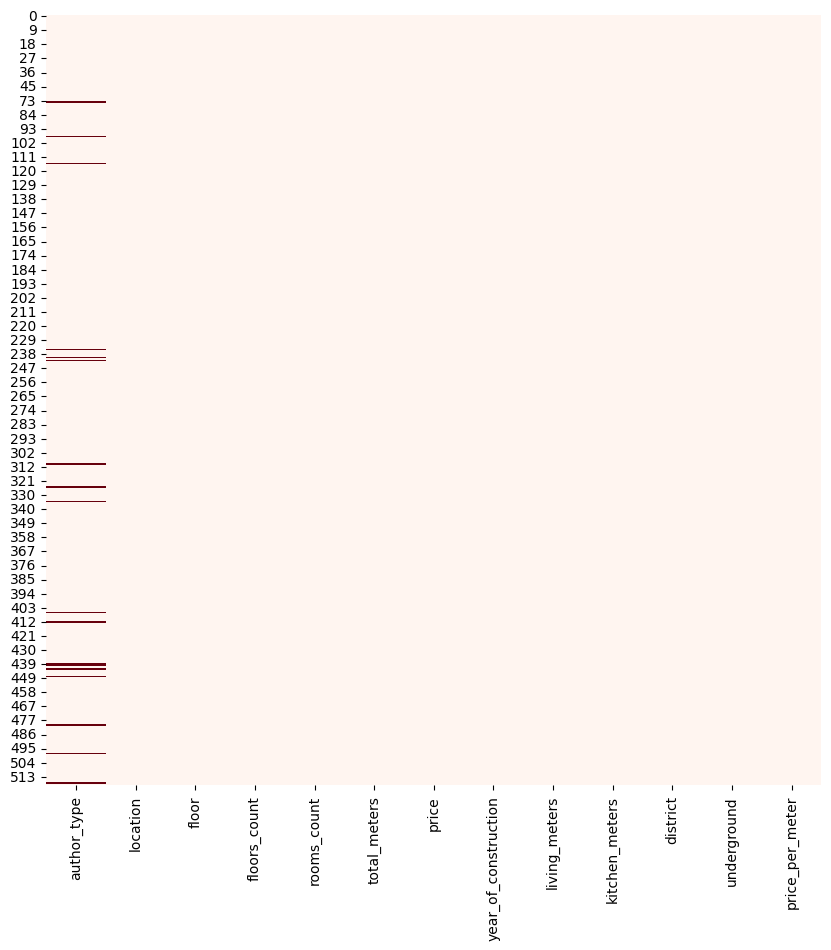

In [283]:
# Хитмапа датасета

plt.figure(figsize=(10, 10))
sb.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.show()

## Зависимость цены квадратного метра в зависимости от параметров

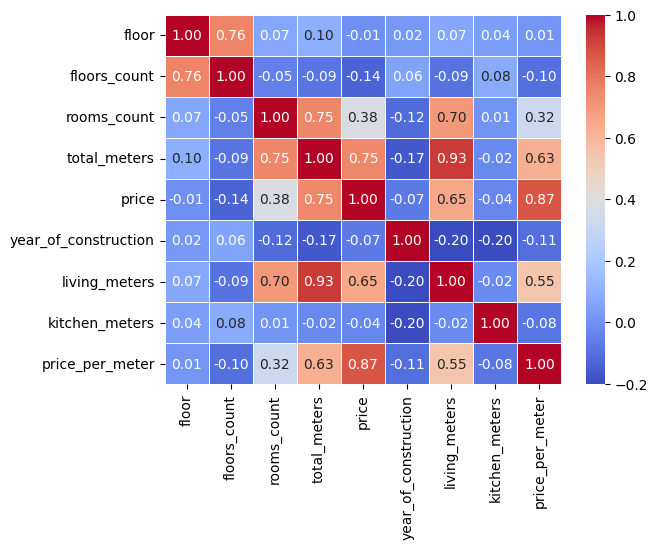

In [284]:
sb.heatmap(df.select_dtypes(include=["number"]).corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

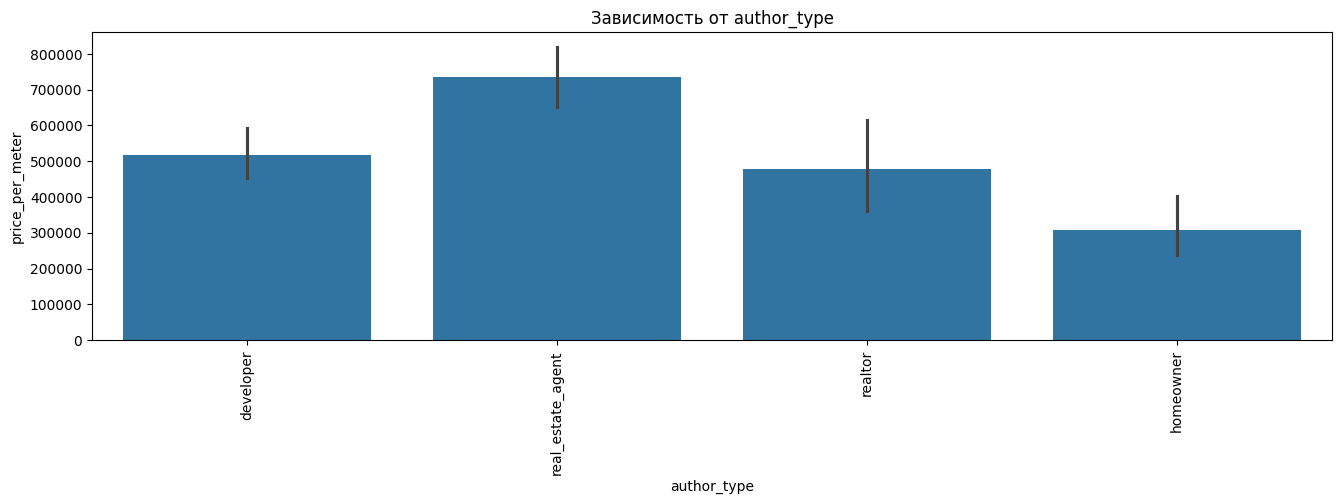

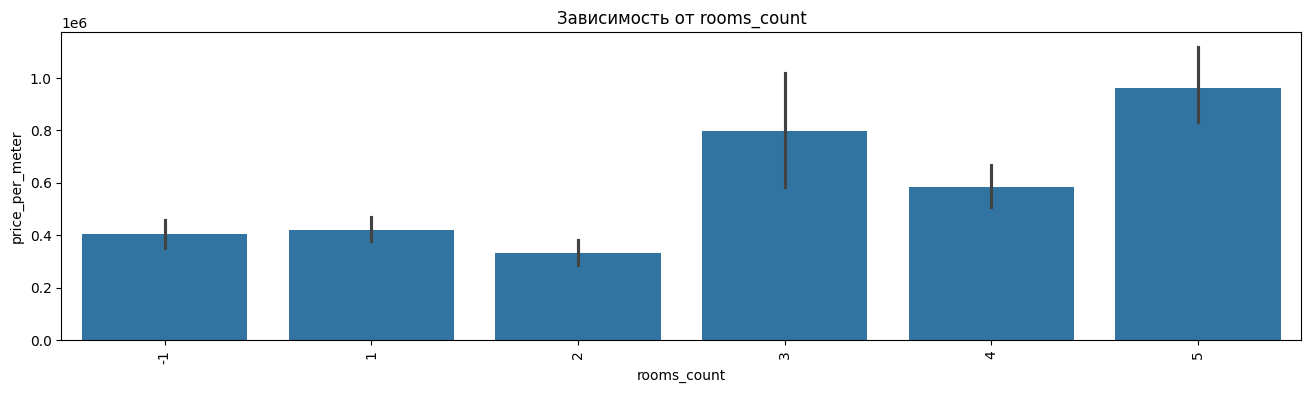

In [285]:
import matplotlib.pyplot as mpl
import seaborn as sns
columns_to_plot = ['author_type', 'rooms_count']
for column in columns_to_plot:
    mpl.figure(figsize=(16, 4))
    sns.barplot(data=df, x=column, y='price_per_meter')
    mpl.title(f'Зависимость от {column}')
    mpl.xlabel(column)
    mpl.xticks(rotation=90)
    mpl.ylabel('price_per_meter')
    mpl.show()

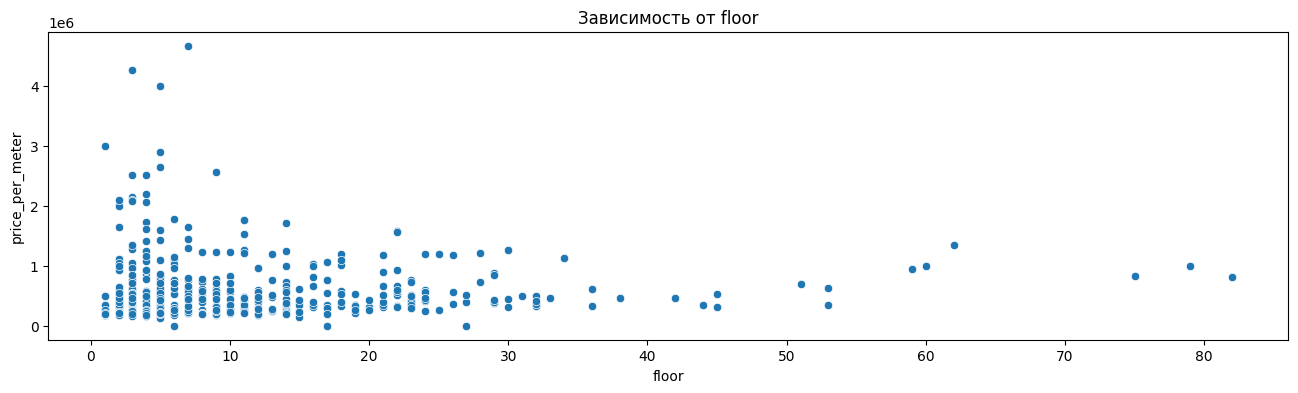

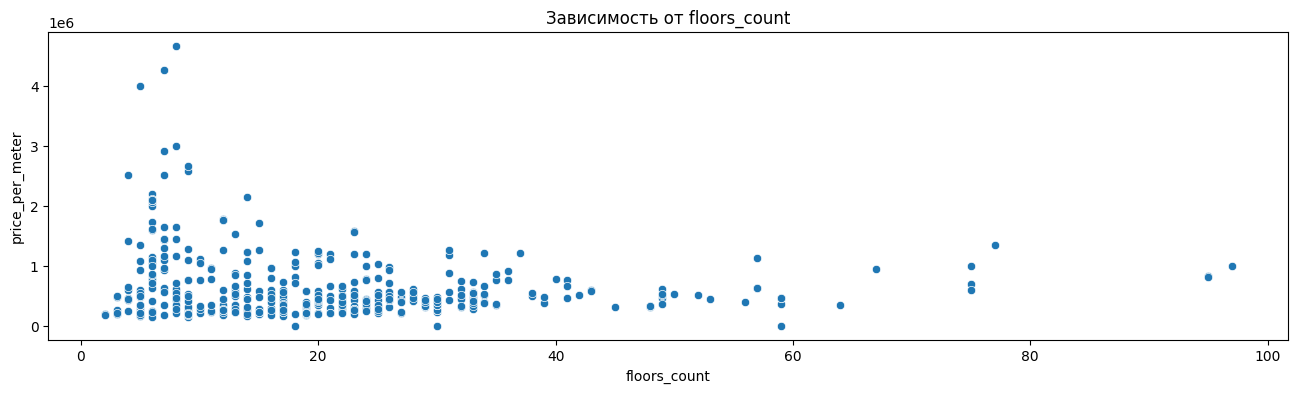

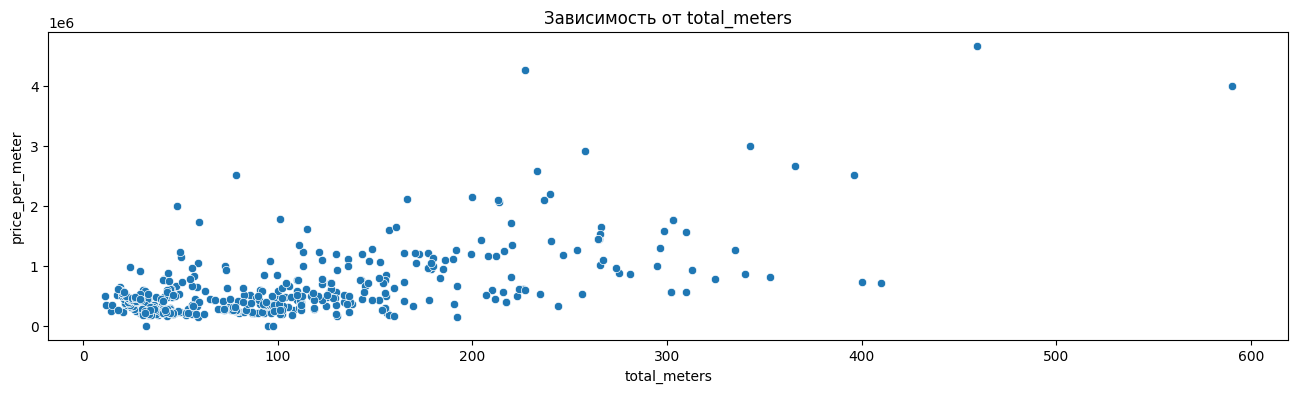

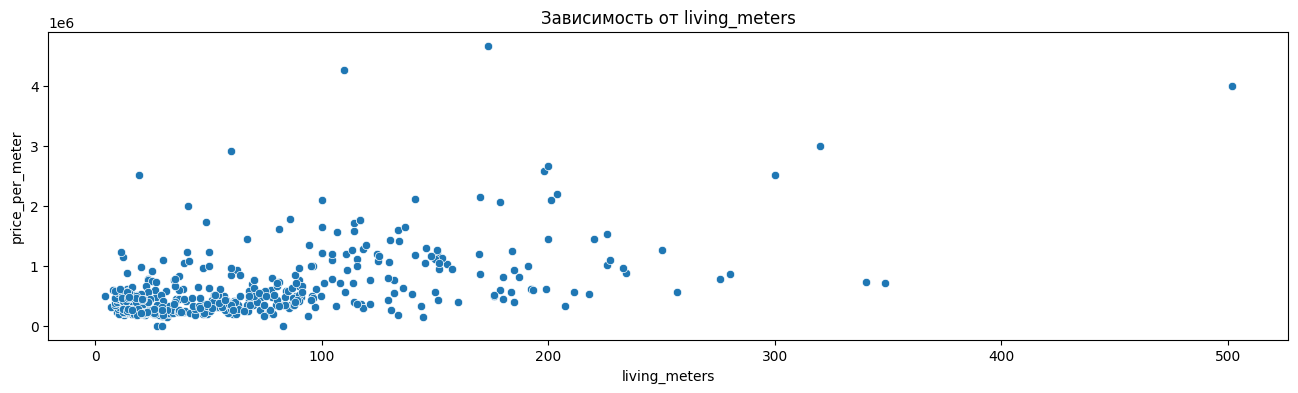

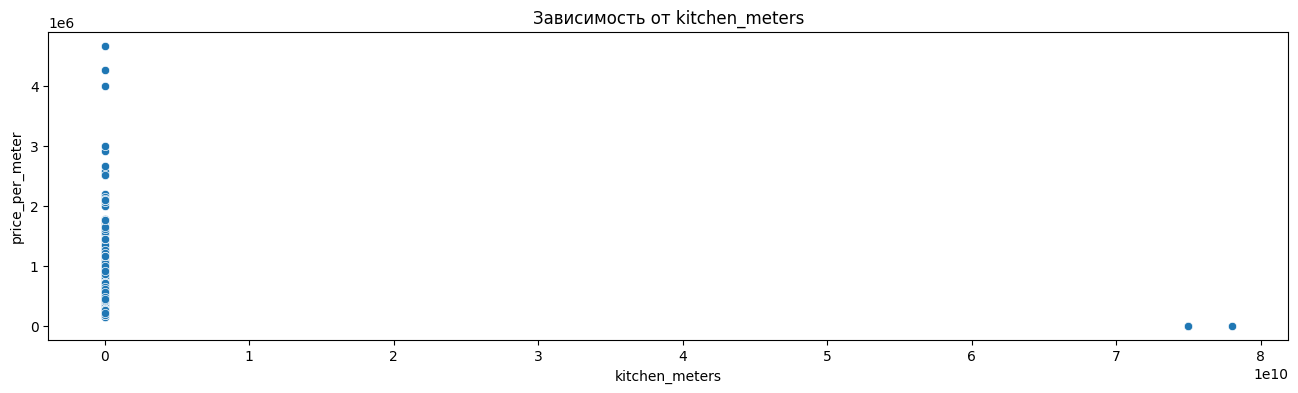

In [286]:
columns_to_plot = ['floor','floors_count','total_meters', "living_meters", "kitchen_meters"]
for column in columns_to_plot:
    mpl.figure(figsize=(16, 4))
    sns.scatterplot(data=df, x=column, y='price_per_meter')
    mpl.title(f'Зависимость от {column}')
    mpl.xlabel(column)
    mpl.ylabel('price_per_meter')
    mpl.show()

## Зависимость цены квадратного метра в зависимости от географического расположения

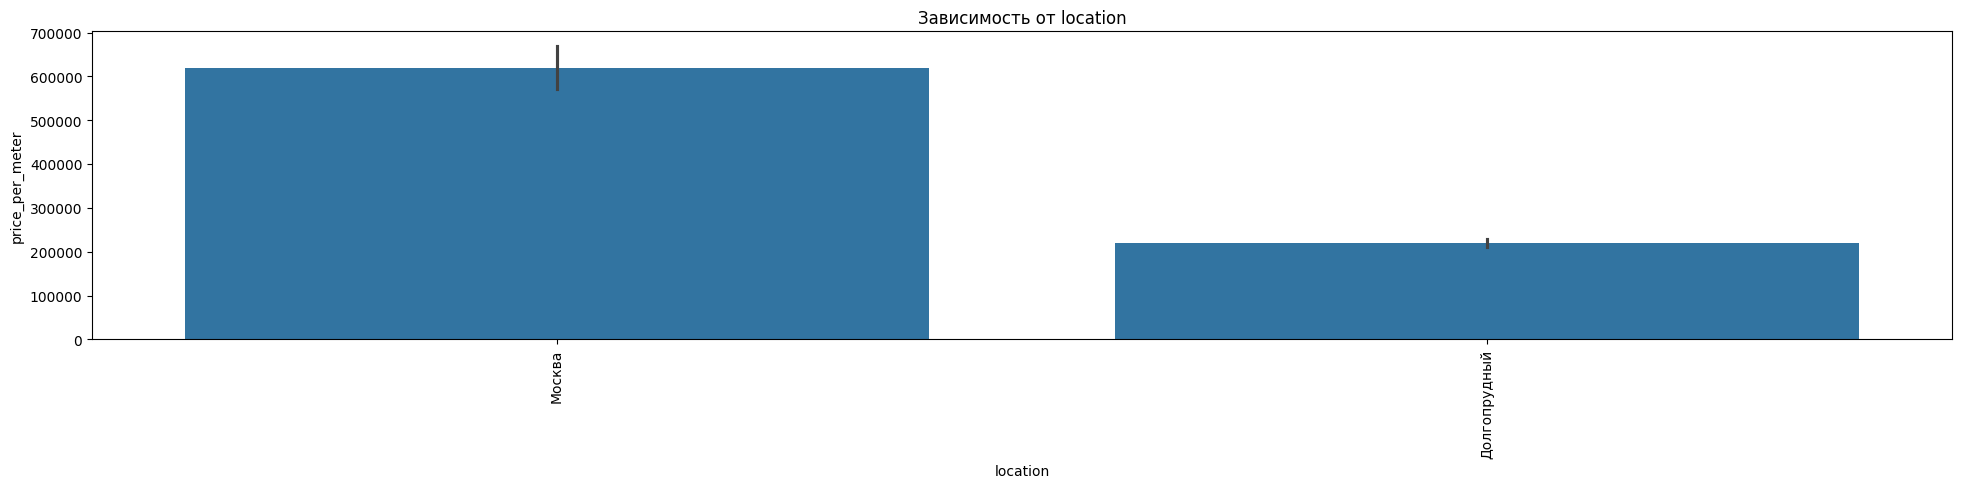

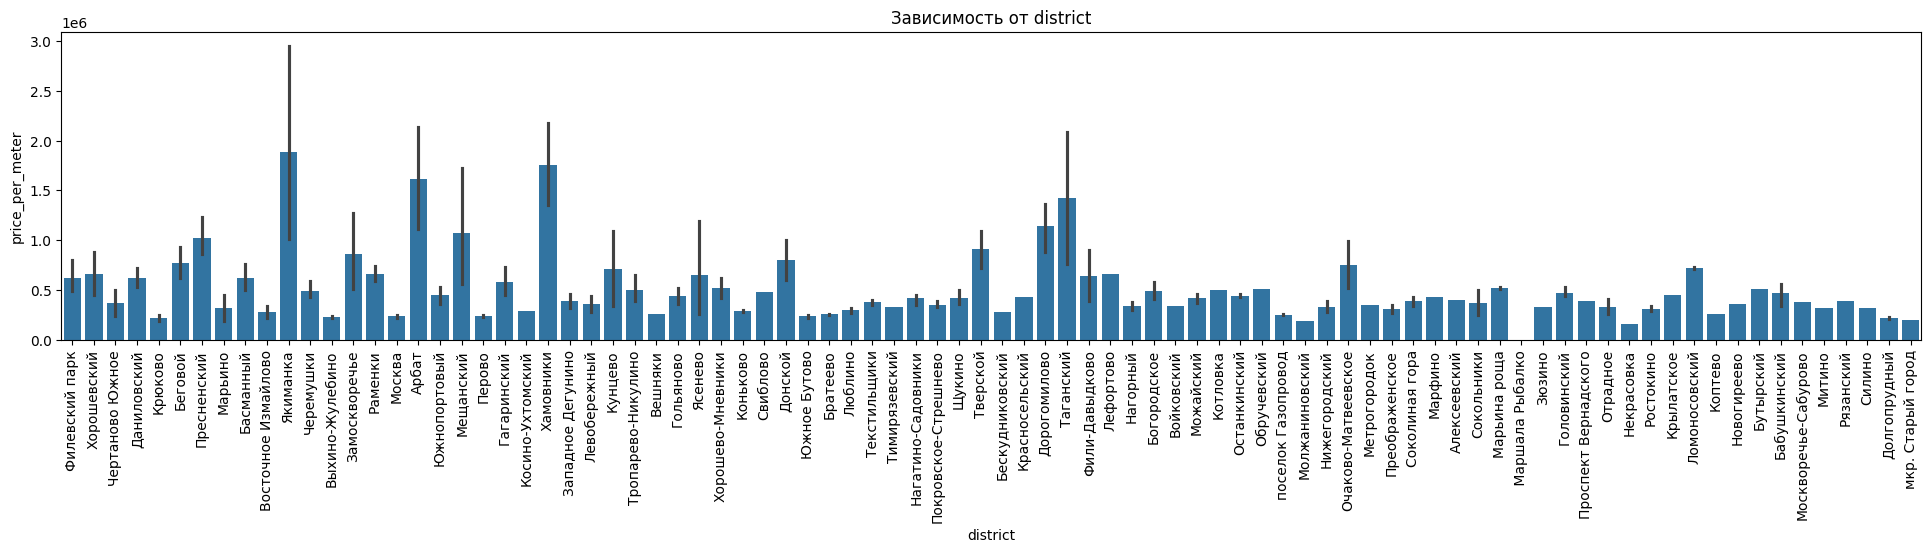

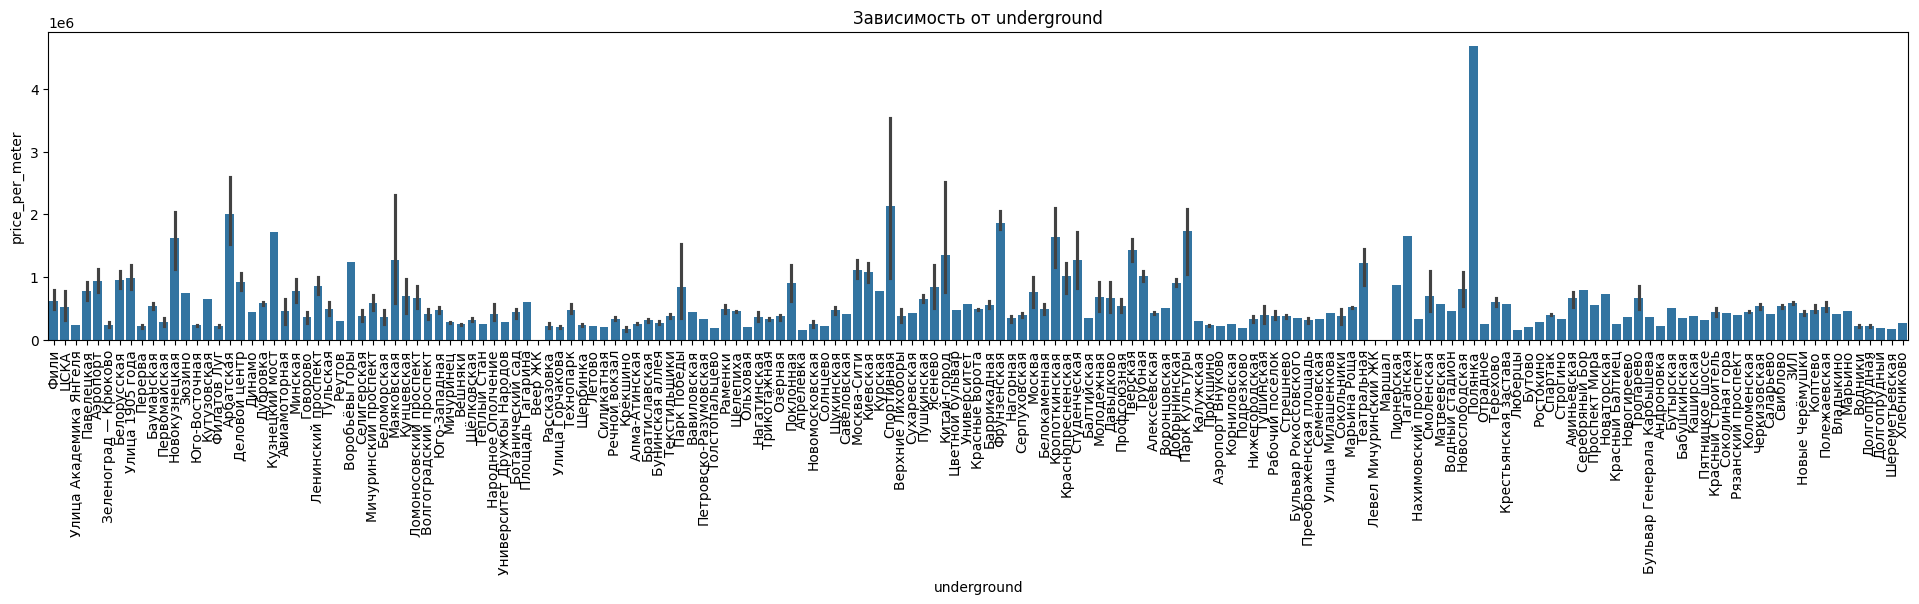

In [287]:
columns_to_plot = ['location', 'district', 'underground']
for column in columns_to_plot:
    mpl.figure(figsize=(24, 4))
    sns.barplot(data=df, x=column, y='price_per_meter')
    mpl.title(f'Зависимость от {column}')
    mpl.xlabel(column)
    mpl.xticks(rotation=90)
    mpl.ylabel('price_per_meter')
    mpl.show()

In [288]:
import catboost